In [1]:
import sys
import pickle
import pandas as pd
path: str = '/Users/juanbeta/My Drive/Research/Energy/E-CVRP-TW/Code/'
#path: str = 'C:/Users/jm.betancourt/Documents/Research/Energy//E-CVRP-TW/Code/'

from E_CVRP_TW import  E_CVRP_TW, Feasibility
env = E_CVRP_TW()

sys.path.insert(0,path+'Experimentation/')
import plot_performance as plot

# Constructive

### Alpha configuration

Testing various alpha configurations

In [2]:
alphas = [0.15, 0.3, 0.5, 'Adaptative-Reactive']
data_alpha = {}
for instance in env.instances:
    data_alpha[instance] = {}
    for alpha in alphas:
        data_alpha[instance][alpha] = plot.retrieve_const_performance(instance, path+f'Experimentation/Constructive/alpha/{alpha}/')

In [3]:
print(' \t \t \t0.15 \t \t \t \t \t0.3 \t \t \t \t \t0.5 \t \t \t \t \tA-R')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

for instance in env.instances[:10]:
    env.load_data(instance)
    things = [instance, len(env.Costumers)]
    for alpha in alphas:
        things += [len(data_alpha[instance][alpha]['best individual']),
                    round(data_alpha[instance][alpha]['best distance'],2),
                    data_alpha[instance][alpha]['gap'],
                    round(data_alpha[instance][alpha]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

 	 	 	0.15 	 	 	 	 	0.3 	 	 	 	 	0.5 	 	 	 	 	A-R
Instance 	M 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s
c101C10.txt	10	4	446.26	13.33	0.05	 	4	446.26	13.33	0.02	 	4	446.26	13.33	0.09	 	4	446.26	13.33	0.02	 
c101C5.txt	5	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 	3	250.04	-2.99	0.0	 
c101_21.txt	100	20	1974.81	87.39	291.86	 	25	2177.8	106.66	147.62	 	24	2386.12	126.42	314.32	 	19	1978.33	87.73	285.96	 
c102_21.txt	100	21	1909.41	80.74	293.19	 	22	2164.92	104.92	351.44	 	22	2362.55	123.63	91.18	 	21	1933.55	83.02	193.59	 
c103C15.txt	15	4	437.79	13.92	2.58	 	5	426.56	11.0	37.59	 	3	409.81	6.64	26.22	 	5	426.56	11.0	24.92	 
c103C5.txt	5	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.0	 	2	165.67	-5.9	0.02	 
c103_21.txt	100	18	1799.87	79.62	116.82	 	19	1951.41	94.75	125.52	 	20	2121.89	111.76	220.37	 	17	1719.19	71.57	449.53	 
c104C10.txt	10	2	281.8	2.87	0.28	 	2	281.8	2.87	0.36	 	2	279.93	2.19	6.96	 	2	279.93	2.19	2.07	 
c104_21.txt

In [4]:
instance = env.sizes['l'][20]
alpha = 0.5

print(f'########## Performance ##########')
print(f'incumbent: {round(data_alpha[instance][alpha]["best distance"],2)}')
print(f'gap: {round((data_alpha[instance][alpha]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_alpha[instance][alpha]["time to find"],2)}')

########## Performance ##########
incumbent: 2009.52
gap: 84.63%
time to find: 266.16


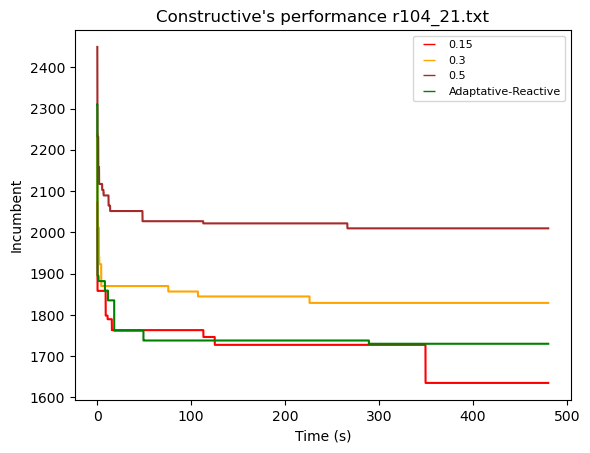

In [5]:
plot.plot_const_performance(data_alpha[instance],instance)

### Restrictive criterion

Testing various restriction configuration for the RCL

In [7]:
criterions = ['distance', 'TimeWindow','Intra-Hybrid', 'Exo-Hybrid']
data_crit = dict()
for instance in env.instances:
    data_crit[instance] = dict()
    for criterion in criterions:
        data = plot.retrieve_const_performance(instance, path+f'Experimentation/Constructive/RCL criterion/{criterion}/')
        data_crit[instance][criterion] = dict() 
        data_crit[instance][criterion]['min_dist'] = data[0]
        data_crit[instance][criterion]['min_EV'] = data[1]

In [11]:
print(' \t \t \tDist \t \t \t \t \tTW \t \t \t \t \tIntra-H \t \t \t \t \tExo-H')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

objective = 'min_EV'

for instance in env.sizes['l'][:10]:
    env.load_data(instance)
    things = [instance, len(env.Costumers)]
    for criterion in criterions:
        things += [len(data_crit[instance][criterion][objective]['best individual']),
                    round(data_crit[instance][criterion][objective]['best distance'],2),
                    data_crit[instance][criterion][objective]['gap'],
                    round(data_crit[instance][criterion][objective]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

 	 	 	Dist 	 	 	 	 	TW 	 	 	 	 	Intra-H 	 	 	 	 	Exo-H
Instance 	M 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s
c101_21.txt	100	22	2258.7	114.33	204.02	 	16	2038.53	93.44	38.48	 	20	2025.72	92.22	464.91	 	18	1942.83	84.36	241.83	 


In [ ]:
instance = env.sizes['l'][4]
criterion = 'TimeWindow'
objective = 'min_EV'

print(f'########## Performance ##########')
print(f'incumbent: {round(data_crit[instance][criterion][objective]["best distance"],2)}')
print(f'gap: {round((data_crit[instance][criterion][objective]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_crit[instance][criterion][objective]["time to find"],2)}')

########## Performance ##########
incumbent: 1839.81
gap: 71.09%
time to find: 145.41


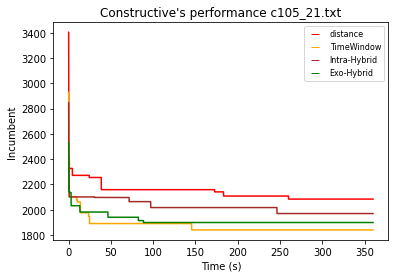

In [21]:
plot.plot_const_performance(data_crit[instance],instance)

# Operators

In [2]:
operators = ['Darwinian phi rate', 'two opt']
data_op = dict()

test_bed = ['c202C10.txt']#, 'c103_21.txt']
instance = test_bed[0]

for instance in test_bed:
    data_op[instance] = dict()
    for operator in operators[1:]:
        data_op[instance][operator] = plot.retrieve_const_performance(instance, path+f'Experimentation/Operators/{operator}/')

In [3]:
env.load_data(instance)
env.generate_parameters()

In [4]:
feas_op = Feasibility()
feasible, _ = feas_op.individual_check(env, data_op[test_bed[0]]['two opt']['best individual'])
print(feasible)

False


In [5]:
_

(219.77927899957655,
 5421.679458437915,
 ([121.6287296115423, 98.15054938803424],
  [3246.6687377876096, 2175.0107206503058]))

In [8]:
data_op[test_bed[0]]['two opt']['best individual']

[['D', 'C8', 'C10', 'C16', 'S7', 'C25', 'C6', 'C30', 'C24', 'S0', 'D'],
 ['D', 'S15', 'C57', 'C96', 'S1', 'C84', 'D']]

In [5]:
individual = data_op[test_bed[0]]['two opt']['best individual']

feas_op = Feasibility()


In [7]:
feasible = True
distance = 0
distances = list()
ttime = 0
times = list()

for num, route in enumerate(individual):
    t = 0
    d = 0
    q = env.Q
    k = 0
    for i in range(len(route)-1):
        node = route[i]
        target = route[i + 1]
        feasible, t, q, k, feas_op.transition_check(env, node, target, t, q, k)
        print(t)

        d += env.dist[node,target]
        if not feasible:
            break
    
    distance += d
    distances.append(d)
    ttime += t
    times.append(t)

    if not feasible:
        break

print(feasible, (distance, ttime, (distances, times)))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
True (250.82762839209659, 0, ([121.6287296115423, 129.1988987805543], [0, 0]))


In [11]:
print(' \t \t \tDist \t \t \t \t \tTW \t \t \t \t \tHybrid')
print('Instance \tM \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts \t \tEV \tFO \tgap \ts')

for instance in env.instances[:10]:
    env.load_data(instance)
    env.generate
    things = [instance, len(env.Costumers)]
    for criterion in criterions:
        things += [len(data_crit[instance][criterion]['best individual']),
                    round(data_crit[instance][criterion]['best distance'],2),
                    data_crit[instance][criterion]['gap'],
                    round(data_crit[instance][criterion]['time to find'],2),
                    ' ']
    print(*things,sep = '\t')

 	 	 	Dist 	 	 	 	 	TW 	 	 	 	 	Hybrid
Instance 	M 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s 	 	EV 	FO 	gap 	s


AttributeError: 'E_CVRP_TW' object has no attribute 'generate'

In [ ]:
instance = env.sizes['l'][20]
criterion = 'distance'

print(f'########## Performance ##########')
print(f'incumbent: {round(data_alpha[instance][criterion]["best distance"],2)}')
print(f'gap: {round((data_alpha[instance][criterion]["best distance"] - env.bkFO[instance])/env.bkFO[instance]*100,2)}%')
print(f'time to find: {round(data_alpha[instance][criterion]["time to find"],2)}')

AttributeError: 'E_CVRP_TW' object has no attribute 'dist'

In [2]:
route = ['D', 1,2,3,4,5,6,7,8,9,10, 'D']



for i in range(1, len(route) - 2):
    for j in range(i+1, len(route)):
        if j-i == 1:
            continue
        new_route = route
        new_route[i:j] = route[j-1:i-1:-1]

print(new_route)

['D', 10, 9, 7, 3, 6, 5, 2, 1, 4, 8, 'D']


In [ ]:
##### Export data to Excel
data = data_crit 

d = {'instance': [], 'M':[]}
for instance in env.instances:
    env.load_data(instance)
    d['instance'].append(instance)
    d['M'].append(len(env.Costumers))

for criterion in criterions:
    d[f'{criterion}/# EV'] = [len(data[instance][criterion]['best individual']) for instance in env.instances]
    d[f'{criterion}/FO'] = [round(data[instance][criterion]['best distance'],2) for instance in env.instances]
    # d[f'{criterion}/gap'] = [data[instance][criterion]['gap'] for instance in env.instances]
    d[f'{criterion}/t'] = [round(data[instance][criterion]['time to find'],2) for instance in env.instances]

df = pd.DataFrame(data = d)
df.to_excel('criterions.xlsx')